In [1]:
import functools
import pyopencl as cl
from pynx.scattering import fhkl as fhkl_module # Get a handle to the module
from pynx.scattering.fhkl import Fhkl_thread as original_Fhkl_thread

# -- Step 1: Helper function to find the best GPU --
def find_best_gpu():
    """Finds the first available OpenCL GPU and returns its platform and device names."""
    for platform in cl.get_platforms():
        # Avoid the CPU-based Intel OpenCL platform if possible
        if 'intel' in platform.name.lower():
            continue
        try:
            gpu_devices = platform.get_devices(device_type=cl.device_type.GPU)
            if gpu_devices:
                # Found a platform with a GPU, return its info
                return platform.name, gpu_devices[0].name
        except cl.Error:
            continue
    raise RuntimeError("Monkey-patch could not find a suitable OpenCL GPU.")

# -- Step 2: Create the wrapper function --
# Use a simple class to store the discovered names so we only search once.
class GpuInfo:
    platform_name = None
    gpu_name = None

@functools.wraps(original_Fhkl_thread)
def patched_Fhkl_thread(*args, **kwargs):
    """
    Wrapper for Fhkl_thread that automatically discovers and sets
    the best cl_platform and gpu_name if they are not provided.
    """
    # Discover GPU info only on the first call
    if GpuInfo.platform_name is None:
        print("Monkey-patch: Discovering best GPU for Fhkl_thread...")
        GpuInfo.platform_name, GpuInfo.gpu_name = find_best_gpu()
        print(f"Monkey-patch: Defaulting to '{GpuInfo.gpu_name}' on platform '{GpuInfo.platform_name}'")

    # Set our defaults, but allow the user to override them
    kwargs.setdefault('language', 'OpenCL')
    kwargs.setdefault('cl_platform', GpuInfo.platform_name)
    kwargs.setdefault('gpu_name', GpuInfo.gpu_name)
    
    # Call the original function with the (potentially modified) arguments
    return original_Fhkl_thread(*args, **kwargs)

# -- Step 3: Apply the patch --
fhkl_module.Fhkl_thread = patched_Fhkl_thread

In [2]:
import numpy as np
import pynx.scattering.fhkl
import time

# Safely import the required GPU libraries
try:
    import pycuda.driver as drv
    import pycuda.compiler as compiler
except ImportError:
    drv, compiler = None, None

try:
    import pyopencl as cl
except ImportError:
    cl = None

print("Applying comprehensive monkey patch to pynx.scattering.fhkl...")

# ==============================================================================
# ===== 1. DEFINE THE PATCH FOR THE OpenCLThread_Fhkl.run METHOD =============
# ==============================================================================
def patched_opencl_run(self):
    # This is a patched version of the original OpenCL run method.
    try_ctx = 5
    while try_ctx > 0:
        try:
            ctx = cl.Context([self.dev])
            try_ctx = 0
        except Exception as e:
            try_ctx -= 1
            print(f"Retrying OpenCL context init... {e}")
            time.sleep(0.1 * (5 - try_ctx))
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # === START OF THE FIX ===
    # Initialize program and kernel variables to None
    CL_program = None
    Fhkl_kernel = None
    # === END OF THE FIX ===
    
    self.block_size = 256
    if self.dev.max_work_group_size < self.block_size:
        self.block_size = self.dev.max_work_group_size
        
    kernel_params = {"block_size": self.block_size}
    options = "-cl-mad-enable -cl-fast-relaxed-math"
    self.context_init = True

    while True:
        self.eventStart.wait()
        if self.join_flag: break
        t0 = time.time()
        natoms = self.x.size
        nhkl = self.h.size
        self.fhkl_real = np.zeros_like(self.h)
        self.fhkl_imag = np.zeros_like(self.h)

        step_atoms = (128 * 1024 * 1024) // (3 * self.x.itemsize)
        step_atoms = (step_atoms // self.block_size) * self.block_size
        if step_atoms <= 0:
            step_atoms = self.block_size
        steps_nbatoms = list(range(0, natoms, step_atoms))
        
        if len(steps_nbatoms) == 0 or steps_nbatoms[-1] != natoms:
            steps_nbatoms.append(natoms)
            
        steps_nhkl = list(range(0, nhkl, 65535 * self.block_size))
        if len(steps_nhkl) == 0 or steps_nhkl[-1] != nhkl:
            steps_nhkl.append(nhkl)

        for j in range(1, len(steps_nhkl)):
            h_chunk, k_chunk, l_chunk = self.h[steps_nhkl[j-1]:steps_nhkl[j]], self.k[steps_nhkl[j-1]:steps_nhkl[j]], self.l[steps_nhkl[j-1]:steps_nhkl[j]]
            fhkl_real_ = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=np.zeros_like(h_chunk, dtype=np.float32))
            fhkl_imag_ = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=np.zeros_like(h_chunk, dtype=np.float32))
            h_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=h_chunk.astype(np.float32))
            k_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=k_chunk.astype(np.float32))
            l_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=l_chunk.astype(np.float32))
            
            for i in range(1, len(steps_nbatoms)):
                tmpx, tmpy, tmpz = self.x[steps_nbatoms[i-1]:steps_nbatoms[i]], self.y[steps_nbatoms[i-1]:steps_nbatoms[i]], self.z[steps_nbatoms[i-1]:steps_nbatoms[i]]
                x_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpx.astype(np.float32))
                y_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpy.astype(np.float32))
                z_ = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=tmpz.astype(np.float32))
                if self.occ is None and self.vkzi is None:
                    # === START OF THE FIX ===
                    if CL_program is None: 
                        CL_program = cl.Program(ctx, pynx.scattering.fhkl.CL_FHKL_CODE % kernel_params).build(options=options)
                        # Retrieve the kernel object once and store it
                        Fhkl_kernel = CL_program.Fhkl
                    # Use the stored kernel object in the loop
                    Fhkl_kernel(queue, (h_chunk.size, 1), (self.block_size, 1), fhkl_real_, fhkl_imag_, x_, y_, z_, np.int64(tmpx.size), h_, k_, l_).wait()
                    # === END OF THE FIX ===
                else: raise NotImplementedError("Patched Fhkl only supports the simple case.")
            
            cl.enqueue_copy(queue, self.fhkl_real[steps_nhkl[j-1]:steps_nhkl[j]], fhkl_real_).wait()
            cl.enqueue_copy(queue, self.fhkl_imag[steps_nhkl[j-1]:steps_nhkl[j]], fhkl_imag_).wait()
            
        self.dt = time.time() - t0
        self.eventStart.clear()
        self.eventFinished.set()

# The CUDA patch from before remains the same
def patched_cuda_run(self):
    dev = drv.Device(self.devID)
    ctx = dev.make_context()
    CUDA_fhkl = None
    self.block_size = 256
    self.context_init = True
    while True:
        self.eventStart.wait()
        if self.join_flag: break
        t0 = time.time()
        natoms = self.x.size
        nhkl = self.h.size
        self.fhkl_real = np.zeros_like(self.h, dtype=np.float32)
        self.fhkl_imag = np.zeros_like(self.h, dtype=np.float32)
        step_atoms = (128 * 1024 * 1024) // (3 * self.x.itemsize)
        step_atoms = (step_atoms // self.block_size) * self.block_size
        if step_atoms <= 0:
            step_atoms = self.block_size
        steps_nbatoms = list(range(0, natoms, step_atoms))
        if len(steps_nbatoms) == 0 or steps_nbatoms[-1] != natoms:
            steps_nbatoms.append(natoms)
        steps_nhkl = list(range(0, nhkl, (2**31 - 1) * self.block_size))
        if len(steps_nhkl) == 0 or steps_nhkl[-1] != nhkl:
            steps_nhkl.append(nhkl)
        for j in range(1, len(steps_nhkl)):
            h_chunk, k_chunk, l_chunk = self.h[steps_nhkl[j - 1]:steps_nhkl[j]], self.k[steps_nhkl[j - 1]:steps_nhkl[j]], self.l[steps_nhkl[j - 1]:steps_nhkl[j]]
            fhkl_real_chunk = self.fhkl_real[steps_nhkl[j-1]:steps_nhkl[j]]
            fhkl_imag_chunk = self.fhkl_imag[steps_nhkl[j-1]:steps_nhkl[j]]
            for i in range(1, len(steps_nbatoms)):
                tmpx, tmpy, tmpz = self.x[steps_nbatoms[i - 1]:steps_nbatoms[i]], self.y[steps_nbatoms[i - 1]:steps_nbatoms[i]], self.z[steps_nbatoms[i - 1]:steps_nbatoms[i]]
                if self.occ is None and self.vkzi is None:
                    if CUDA_fhkl is None:
                        mod_fhkl = compiler.SourceModule(pynx.scattering.fhkl.mod_fhkl_str % (self.block_size), options=["-use_fast_math"])
                        CUDA_fhkl = mod_fhkl.get_function("CUDA_fhkl")
                    CUDA_fhkl(drv.InOut(fhkl_real_chunk), drv.InOut(fhkl_imag_chunk),
                              drv.In(tmpx.astype(np.float32)), drv.In(tmpy.astype(np.float32)), drv.In(tmpz.astype(np.float32)),
                              np.int64(tmpx.size),
                              drv.In(h_chunk.astype(np.float32)), drv.In(k_chunk.astype(np.float32)), drv.In(l_chunk.astype(np.float32)),
                              block=(self.block_size, 1, 1), grid=((h_chunk.size) // self.block_size, 1))
                else: raise NotImplementedError("Patched Fhkl only supports the simple case.")
        self.dt = time.time() - t0
        self.eventStart.clear()
        self.eventFinished.set()
    ctx.pop()

# ==============================================================================
# ===== 3. APPLY THE PATCHES ===================================================
# ==============================================================================
if cl is not None:
    pynx.scattering.fhkl.OpenCLThread_Fhkl.run = patched_opencl_run
    print("✅ OpenCL backend patched.")
if drv is not None and compiler is not None:
    pynx.scattering.fhkl.CUDAThread_Fhkl.run = patched_cuda_run
    print("✅ CUDA backend patched.")

Applying comprehensive monkey patch to pynx.scattering.fhkl...
✅ OpenCL backend patched.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.fft import fftn, ifftshift, fftshift

from pynx.scattering.fhkl import Fhkl_thread

import cdiutils
cdiutils.update_plot_params()

#### We need to add all the functions related to simulations in `cdiutils.simulations` submodule

In [4]:
def read_lammps_positions(
        file_path: str,
        separate_atoms: bool = False,
        centre: bool =True
) -> np.ndarray | dict:
    """
    Reads atom positions from a LAMMPS .xyz or .lmp (dump) file.

    Args:
        file_path (str): path to the input file.
        separate_atoms (bool, optional): if True, separates positions by
            atom type. If False, returns all positions in one array.
            Defaults to False.

    Returns:
        dict or np.ndarray:
            - If separate_atoms=True, returns a dictionary {atom_type:
                positions_array}.
            - If separate_atoms=False, returns a single array of all
            positions.

    Raises:
        ValueError: if the file type cannot be detected or the file
            cannot be parsed.
    """
    # initialise storage for positions and atom types
    positions = []
    atom_types = []

    with open(file_path, 'r') as file:
        if file_path.endswith("xyz"):
            # Parse .xyz file
            file.readline()  # nb of atoms
            file.readline()  # comment line
            
            # parse atom positions
            for line in file:
                split_line = line.strip().split()
                atom_type = split_line[0]  # Atom type is the first column
                position = list(map(float, split_line[1:4]))  # x, y, z pos
                atom_types.append(atom_type)
                positions.append(position)

        elif file_path.endswith("lmp"):
            pass

    # convert to arrays
    positions = np.array(positions)

    # Atom should centred with respect to the centroid of ALL atoms
    if centre:
        positions -= np.mean(positions, axis=0, keepdims=True)

    if separate_atoms:
        # group positions by atom type
        separated_positions = {atom_type: [] for atom_type in atom_types}
        for atom_type, position in zip(atom_types, positions):
            separated_positions[atom_type].append(position)

        # convert lists to arrays
        for atom_type in separated_positions:
            separated_positions[atom_type] = np.array(
                separated_positions[atom_type]
            ).T
            # print(np.mean(separated_positions[atom_type], axis=1))
            # separated_positions[atom_type] -= np.mean(
            #     separated_positions[atom_type], axis=1, keepdims=True
            # )

        return dict(separated_positions)
    else:
        # return all positions in a single array
        return positions.T


In [5]:
# 12x faster
import polars as pl
import numpy as np

def read_lammps_positions_polars(
    file_path: str,
    separate_atoms: bool = False,
    centre: bool = True
) -> np.ndarray | dict:
    """
    Reads atom positions from a LAMMPS .xyz file using the high-performance
    Polars library. This version returns float64 data as a workaround for
    potential downstream library bugs.
    """
    # Or Float32 to save memory, as PyNX only works with that anyway.
    schema_overrides = {
        'atom_type': pl.Categorical,
        'x': pl.Float32,
        'y': pl.Float32,
        'z': pl.Float32,
    }

    lf = pl.scan_csv(
        file_path,
        skip_rows=2,
        separator=" ",
        has_header=False,
        new_columns=['atom_type', 'x', 'y', 'z'],
        schema_overrides=schema_overrides
    )

    if centre:
        lf = lf.with_columns(
           (pl.col(['x', 'y', 'z']) - pl.col(['x', 'y', 'z']).mean())
        )

    df = lf.collect(engine='streaming')

    if separate_atoms:
        partitioned_dfs = df.partition_by('atom_type', as_dict=True)
        return {
            atom_type: data.select(['x', 'y', 'z']).to_numpy().T
            for atom_type, data in partitioned_dfs.items()
        }
    else:
        return df.select(['x', 'y', 'z']).to_numpy().T

In [6]:
path = (
    #"Pt_minimized.xyz"
    #"/data/id01/inhouse/polack/shared/for_clement/exp_minimized.xyz"
    #'/data/id01/inhouse/corentin/lammps/Pt/nanosculpt/div10_oriented_v2.5/NP_Pt_nanosculpt_div10_oriented_v2.5_minimized.xyz'
    '/data/id01/inhouse/corentin/lammps/Pt/nanosculpt/div1/NP_Pt_nanosculpt_div1_minimized.xyz'
)

#positions = read_lammps_positions(path, centre=True)

#print(f"Shape: {positions.shape}")

In [7]:
#%%timeit -n 1 -r 1

positions = read_lammps_positions_polars(path, centre=True)
print(f"Shape: {positions.shape}")

Shape: (3, 211890650)


A simple sanity check

#### Some parameters
- Here we are going to simulate an X-ray scattering experiment. For that we need to define where we are going to look at in the reciprocal space. Therefore, we need:
    * a Bragg reflection (`hkl`)
    * a lattice parameter

- We also need to specify how fine we want our reciprocal space grid to be. This is basically defined by:
    * the number of steps (`step_nb`), the higher the better the resolution, oversampling
    * the reciprocal space resolution (`dq`)
    * the lattice parameter

In [8]:
hkl = [1, 1, 1]
original_vector = np.array(hkl) / np.linalg.norm(hkl)
target_vector = np.array([0, 0, 1], dtype=float)
target_vector /= np.linalg.norm(target_vector)

rotation_axis = np.cross(original_vector, target_vector)
rotation_axis /= np.linalg.norm(rotation_axis)
angle = np.arccos(np.dot(original_vector, target_vector)) 

rotation = Rotation.from_rotvec(angle * rotation_axis)
rotated_hkl = rotation.apply(np.column_stack(hkl))

# extract rotated x, y, z arrays
rotated_hkl = rotated_hkl.T

In [9]:
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'


Starting scattering computation for 211890650 atoms...
Monkey-patch: Discovering best GPU for Fhkl_thread...
Monkey-patch: Defaulting to 'NVIDIA A40' on platform 'NVIDIA CUDA'
Fhkl_thread: init gputhreads with GPU=, language=,cl_platform=NVIDIA CUDA
NVIDIA A40
Thread Thread-5: finished __init__
Starting thread:Thread-5
Initialized 1 PyNX threads for:  (language= , NVIDIA CUDA), actual=OpenCL (NVIDIA CUDA):NVIDIA A40)
Thread # 0 [0, 211890650]
Thread #0, dt=1983.10936
✅ Scattering computation finished in 1983.14 seconds.


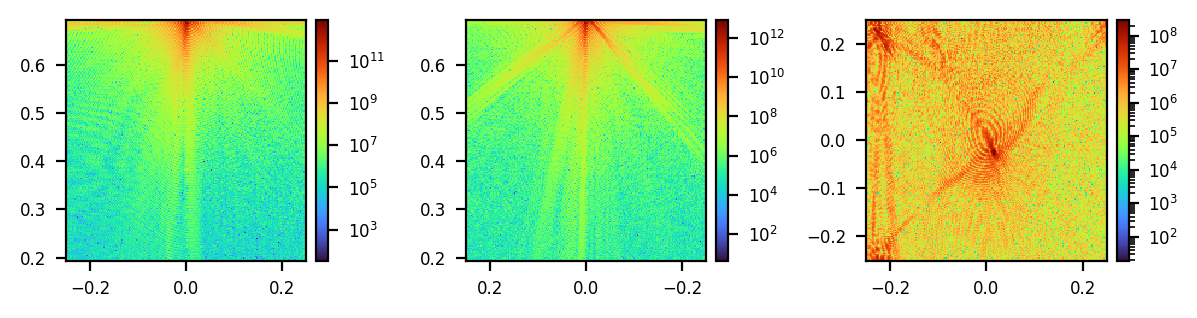

Elapsed time for the scattering computation: 1983.1437685489655 s
Spatial resolution in the direct space:  0.7839195979899498 0.7839195979899498 0.7839195979899501 nm


In [10]:
lattice_parameter = 3.9
d_spacing = lattice_parameter / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)

step_nb = 800
step_nb = 400
dq = np.array([1, 1, 1]) / step_nb

q_size = (200, 200, 200)

# Let us build the reciprocal space grid
q_ranges = []
for i in range(3):
    q_ranges.append(
        (rotated_hkl[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i])
        / lattice_parameter
    )
q_grid = np.meshgrid(*q_ranges, indexing="ij")

print(f"\nStarting scattering computation for {positions.shape[1]} atoms...")
scattered_amp, dt = Fhkl_thread(
    *q_grid,
    *positions,
    occ=None,
    gpu_name="",
    language="",
    verbose=True,
)
print(f"✅ Scattering computation finished in {dt:.2f} seconds.")

diffraction_pattern = np.abs(scattered_amp)**2

cdiutils.plot.plot_volume_slices(
    diffraction_pattern,
    norm="log",
    voxel_size=(dq[0], dq[1], dq[2]),
    data_centre=[np.mean(q) for q in q_grid],
    convention="xu",
)

print(
    f"Elapsed time for the scattering computation: {dt} s\n"
    "Spatial resolution in the direct space: ",
    1 / np.ptp(q_grid[0]) * .1, 1 / np.ptp(q_grid[1]) * .1, 1 / np.ptp(q_grid[2]) * .1, "nm"
)

In [11]:
from scipy.ndimage import center_of_mass
from pynx.scattering import Fhkl_thread

# The new, fast center-of-mass function from above
def find_bragg_peak_centre_fast(diffraction_pattern: np.ndarray, q_grid: tuple) -> tuple:
    threshold = diffraction_pattern.max() * 0.1
    mask = diffraction_pattern > threshold
    indices_com = center_of_mass(diffraction_pattern, labels=mask)
    qx, qy, qz = q_grid
    # Map indices to q-space coordinates. Note the careful indexing.
    q_com = (
        qx[int(round(indices_com[0])), 0, 0],
        qy[0, int(round(indices_com[1])), 0],
        qz[0, 0, int(round(indices_com[2]))]
    )
    return q_com

def refine_q_grid(
    positions: tuple,
    hkl: np.ndarray,
    lattice_parameter_guess: float,
    q_size: tuple = (200, 200, 200),
    step_nb: int = 400,
    max_iterations: int = 5,
    convert_to_angstrom: bool = True
):
    """
    Iteratively refine the q-grid to center the Bragg peak.

    Args:
        positions: atomic positions
        hkl: Miller indices
        lattice_parameter_guess: initial lattice parameter guess in
            meters. Will be converted to Angstrom if convert_to_angstrom is True.
        convert_to_angstrom: if True, converts lattice parameter to Angstrom
        q_size: size of q-grid
        step_nb: number of steps for dq calculation
        max_iterations: maximum refinement iterations

    Returns:
        tuple: (
            refined_q_grid, scattered_amp, refined_lattice_parameter
        )
    """
    unit = "m"
    rcp_space_unit = "1/m"
    if convert_to_angstrom:
        lattice_parameter_guess *= 1e10
        unit = "angstrom"
        rcp_space_unit = "1/angstrom"

    current_lattice = lattice_parameter_guess
    current_center = hkl / current_lattice

    for iteration in range(max_iterations):
        print(f"Refinement iteration {iteration + 1}")
        print(f"Current lattice parameter: {current_lattice:.4f}")
        print(f"Current center: {current_center}")

        # build q-grid around current center
        dq = np.array([1, 1, 1]) / step_nb  # step size in reciprocal space
        q_ranges = []
        for i in range(3):
            q_ranges.append(
                current_center[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i]
            )
        q_grid = np.meshgrid(*q_ranges, indexing="ij")

        # calculate the kinematic scattering
        scattered_amp, dt = Fhkl_thread(
            *q_grid, *positions, occ=None, language='', gpu_name='',
        )

        diffraction_pattern = np.abs(scattered_amp) ** 2

        # find the actual peak center
        peak_center = find_bragg_peak_centre(diffraction_pattern, q_grid)
        print(f"Found peak center at: {peak_center}")

        # calculate shift from expected center
        expected_center = [np.mean(q) for q in q_grid]
        shift = [pc - ec for pc, ec in zip(peak_center, expected_center)]

        print(f"Shift from grid center: {shift} {rcp_space_unit}")

        # update center for next iteration
        current_center = peak_center

        # optionally refine lattice parameter based on peak position
        # the magnitude of the q-vector should match 2π/d_spacing
        q_magnitude = np.linalg.norm(peak_center)
        theoretical_q = np.linalg.norm(hkl) / current_lattice

        # refine lattice parameter
        lattice_correction = theoretical_q / q_magnitude
        current_lattice *= lattice_correction
        current_center = [c / lattice_correction for c in current_center]

        print(f"Refined lattice parameter: {current_lattice:.4f} {unit}")
        print(f"Shift magnitude: {np.linalg.norm(shift):.6f} {rcp_space_unit}")
        print("-" * 50)

        # check convergence
        if (
            np.linalg.norm(shift) < dq[0] * 0.1
        ):  # Converged if shift < 10% of pixel size
            print("Converged!")
            break

    return q_grid, scattered_amp, current_lattice

In [12]:
initial_lattice_guess = 3.92e-10  # Your initial guess
step_nb = 1600
q_size = (200, 200, 200)

# Refine the q-grid
refined_q_grid, scattered_amp, refined_lattice = refine_q_grid(
    positions, rotated_hkl, initial_lattice_guess, 
    q_size=q_size, 
    step_nb=step_nb, 
    max_iterations=10
)

print(f"Final refined lattice parameter: {refined_lattice:.4f}")

# Plot the refined result
dq = np.array([1, 1, 1]) / step_nb
fig, axes = cdiutils.plot.plot_volume_slices(
    np.abs(scattered_amp) ** 2,
    norm="log",
    voxel_size=(dq[0], dq[1], dq[2]),
    data_centre=[np.mean(q) for q in refined_q_grid],
    convention="xu",
    show=False
)
cdiutils.plot.add_labels(axes, convention="xu")
display(fig)

Refinement iteration 1
Current lattice parameter: 3.9200
Current center: [[2.12415120e-17]
 [2.83220159e-17]
 [4.41849696e-01]]


KeyboardInterrupt: 

In [ ]:
print(
    f"Elapsed time for the scattering computation: {dt} s\n"
    "Spatial resolution in the direct space: ",
    1 / np.ptp(refined_q_grid) * .1, 1 / np.ptp(refined_q_grid) * .1, 1 / np.ptp(refined_q_grid ) * .1, "nm"
)
    

In [ ]:
q_com = find_bragg_peak_centre(
    np.abs(scattered_amp)**2, refined_q_grid
)
d_spacing = 1 / np.linalg.norm(q_com)
print(
    f"d-spacing and associated lattice parameter are: {d_spacing} and "
    f"{d_spacing * np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)} A."
)

In [ ]:
voxel_size = tuple(1e-1 / np.ptp(q) for q in refined_q_grid)  # in nm
obj = fftshift(fftn(ifftshift(np.conj(scattered_amp))))

support = cdiutils.utils.make_support(np.abs(obj), isosurface=0.75)
plot_params = {
    "support": support, "convention": "xu", "voxel_size": voxel_size,
    "data_centre": (0, 0, 0), "show": True,
}
# cdiutils.plot.plot_volume_slices(np.abs(obj))
cdiutils.plot.plot_volume_slices(np.abs(obj), **plot_params)
fig, axes = cdiutils.plot.plot_volume_slices(
    np.angle(obj), cmap="cet_CET_C9s_r", vmin=-np.pi, vmax=np.pi, **plot_params
)
cdiutils.plot.add_labels(axes, convention="xu")
display(fig)

In [ ]:
obj = cdiutils.process.PostProcessor.apodize(obj)
struct_properties = cdiutils.process.PostProcessor.get_structural_properties(
    obj,
    isosurface=0.65,
    g_vector=tuple(q * (2*np.pi) for q in q_com),
    hkl=[1, 1, 1],
    voxel_size=voxel_size,
    phase_factor=1
)
for k in struct_properties:
    print(k)

In [ ]:
for k in ("amplitude", "phase", "het_strain_from_dspacing", "lattice_parameter"):
    plot_params.update(cdiutils.plot.get_plot_configs(k))
    plot_params["vmin"], plot_params["vmax"] = None, None
    cdiutils.plot.plot_volume_slices(struct_properties[k], **plot_params)

print(np.nanmean(struct_properties["lattice_parameter"]))